# Sentiment Analysis of Indian Union Budget Speeches (2023-2026)

This notebook performs comprehensive NLP-based sentiment analysis on three Indian Union Budget speeches:
- **2023-24** (Feb 1, 2023) — Amrit Kaal theme, 7 priorities
- **2024-25** (Jul 23, 2024) — Viksit Bharat, 9 priorities
- **2026-27** (Feb 1, 2026) — SMEs, Infrastructure, AI, Healthcare, Tourism

**Analysis includes:** EDA, Word Clouds, N-gram Analysis, VADER Sentiment, TextBlob, TF-IDF, LDA Topic Modeling, Theme-wise Sentiment Heatmap, and Cross-Year Comparisons.

In [1]:
# Cell 1 — Imports & Setup
import nltk
import re
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import Counter, defaultdict
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

warnings.filterwarnings('ignore')

# Download required NLTK data
for pkg in ['punkt', 'punkt_tab', 'stopwords', 'vader_lexicon', 'wordnet', 'omw-1.4']:
    nltk.download(pkg, quiet=True)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Year colors
YEAR_COLORS = {
    '2023-24': '#2196F3',
    '2024-25': '#4CAF50',
    '2026-27': '#FF5722'
}
YEARS = ['2023-24', '2024-25', '2026-27']

# Output directory (same folder as notebook)
OUTPUT_DIR = '.'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Setup complete. Libraries loaded successfully.')
print(f'Output directory: {os.path.abspath(OUTPUT_DIR)}')

Setup complete. Libraries loaded successfully.
Output directory: /Users/saikiran/dhanu/budget_sentiment_analysis


In [2]:
# Cell 2 — Data Loading
FILE_MAP = {
    '2023-24': '../bs2023_24.txt',
    '2024-25': '../budget_speech 2024-2025.txt',
    '2026-27': '../budget_speech.txt'
}

raw_texts = {}
for year, filepath in FILE_MAP.items():
    try:
        with open(filepath, 'r', encoding='utf-8', errors='replace') as f:
            raw_texts[year] = f.read()
        print(f'Budget {year}: {len(raw_texts[year]):,} characters loaded from "{filepath}"')
    except FileNotFoundError:
        print(f'ERROR: File not found for {year}: {filepath}')

print(f'\nTotal speeches loaded: {len(raw_texts)}')

Budget 2023-24: 99,162 characters loaded from "../bs2023_24.txt"
Budget 2024-25: 104,945 characters loaded from "../budget_speech 2024-2025.txt"
Budget 2026-27: 98,516 characters loaded from "../budget_speech.txt"

Total speeches loaded: 3


In [3]:
# Cell 3 — Text Preprocessing
lemmatizer = WordNetLemmatizer()
nltk_stopwords = set(stopwords.words('english'))

CUSTOM_STOPWORDS = {
    'crore', 'lakh', 'rs', 'rupees', 'hon', 'ble', 'government', 'india',
    'budget', 'speaker', 'minister', 'finance', 'madam', 'sir', 'year',
    'also', 'per', 'cent', 'said', 'one', 'two', 'three', 'shall', 'would',
    'may', 'well', 'will', 'us', 'upon', 'new', 'i', 'ii', 'iii', 'iv',
    'member', 'country', 'scheme', 'sector', 'state', 'national', 'programme',
    'provide', 'provided', 'billion', 'million', 'thousand', 'hundred',
    'announced', 'announce', 'proposed', 'propose', 'hon\'ble', 'honble'
}
ALL_STOPWORDS = nltk_stopwords | CUSTOM_STOPWORDS


def preprocess_text(text):
    """Lowercase, remove special chars/numbers, strip whitespace."""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


def tokenize_and_clean(text):
    """Tokenize, lemmatize, remove stop words."""
    tokens = word_tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok.isalpha() and len(tok) > 2 and tok not in ALL_STOPWORDS
    ]
    return cleaned


def get_sentences(text):
    """Sentence tokenize using NLTK."""
    return sent_tokenize(text)


processed = {}
tokens = {}
sentences = {}

for year, text in raw_texts.items():
    proc = preprocess_text(text)
    processed[year] = proc
    tokens[year] = tokenize_and_clean(proc)
    sentences[year] = get_sentences(text)
    print(f'{year}: {len(tokens[year]):,} clean tokens | {len(sentences[year]):,} sentences')

print('\nPreprocessing complete.')

2023-24: 6,874 clean tokens | 692 sentences
2024-25: 7,335 clean tokens | 774 sentences
2026-27: 7,998 clean tokens | 817 sentences

Preprocessing complete.


=== Basic Statistics ===
         Characters  Total Words  Unique Tokens  Sentences  Avg Words/Sentence  Vocabulary Richness (%)
Year                                                                                                   
2023-24       99162        14041           2100        692                20.3                     30.5
2024-25      104945        14853           2107        774                19.2                     28.7
2026-27       98516        15579           2352        817                19.1                     29.4


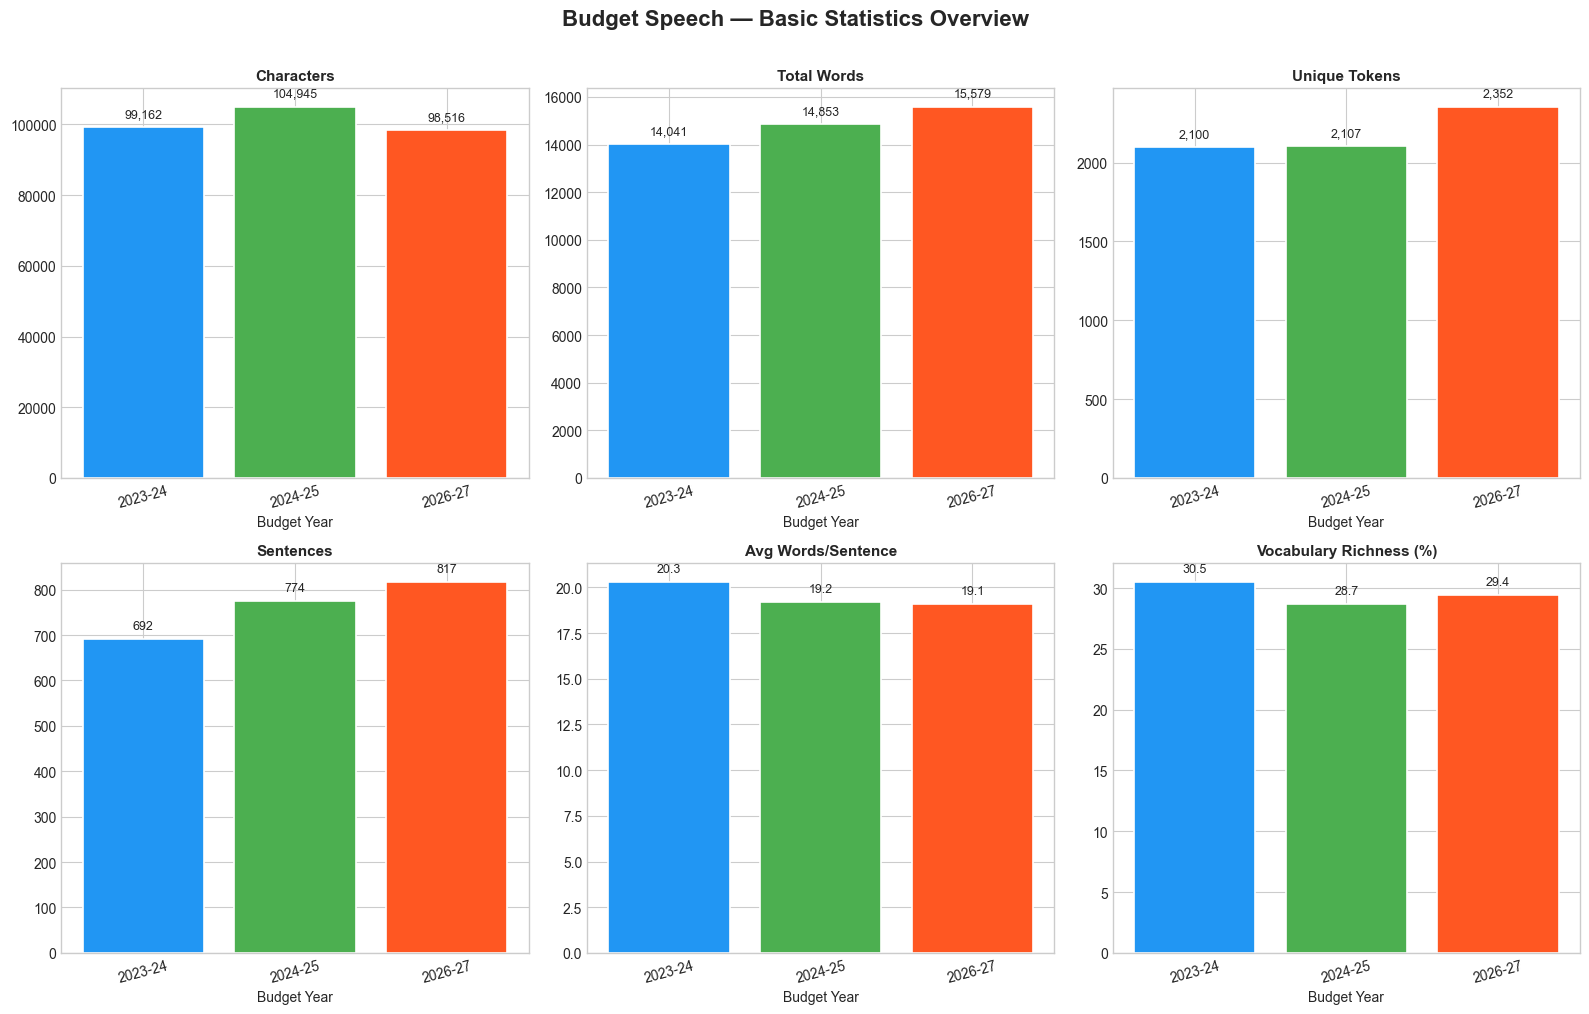

Saved: stats_overview.png


In [4]:
# Cell 4 — Basic Statistics (EDA)
stats_data = []
for year in YEARS:
    text = raw_texts[year]
    toks = tokens[year]
    sents = sentences[year]
    all_words = text.split()
    unique_toks = set(toks)
    vocab_richness = (len(unique_toks) / len(toks) * 100) if toks else 0
    avg_words_per_sent = (len(all_words) / len(sents)) if sents else 0

    stats_data.append({
        'Year': year,
        'Characters': len(text),
        'Total Words': len(all_words),
        'Unique Tokens': len(unique_toks),
        'Sentences': len(sents),
        'Avg Words/Sentence': round(avg_words_per_sent, 1),
        'Vocabulary Richness (%)': round(vocab_richness, 1)
    })

stats_df = pd.DataFrame(stats_data).set_index('Year')
print('=== Basic Statistics ===' )
print(stats_df.to_string())

# 6-panel bar chart
metrics = ['Characters', 'Total Words', 'Unique Tokens', 'Sentences',
           'Avg Words/Sentence', 'Vocabulary Richness (%)']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Budget Speech — Basic Statistics Overview', fontsize=16, fontweight='bold', y=1.01)

for ax, metric in zip(axes.flatten(), metrics):
    vals = [stats_df.loc[y, metric] for y in YEARS]
    bars = ax.bar(YEARS, vals, color=[YEAR_COLORS[y] for y in YEARS], edgecolor='white', linewidth=1.2)
    ax.set_title(metric, fontsize=11, fontweight='bold')
    ax.set_xlabel('Budget Year')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.02,
                f'{val:,}', ha='center', va='bottom', fontsize=9)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stats_overview.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: stats_overview.png')

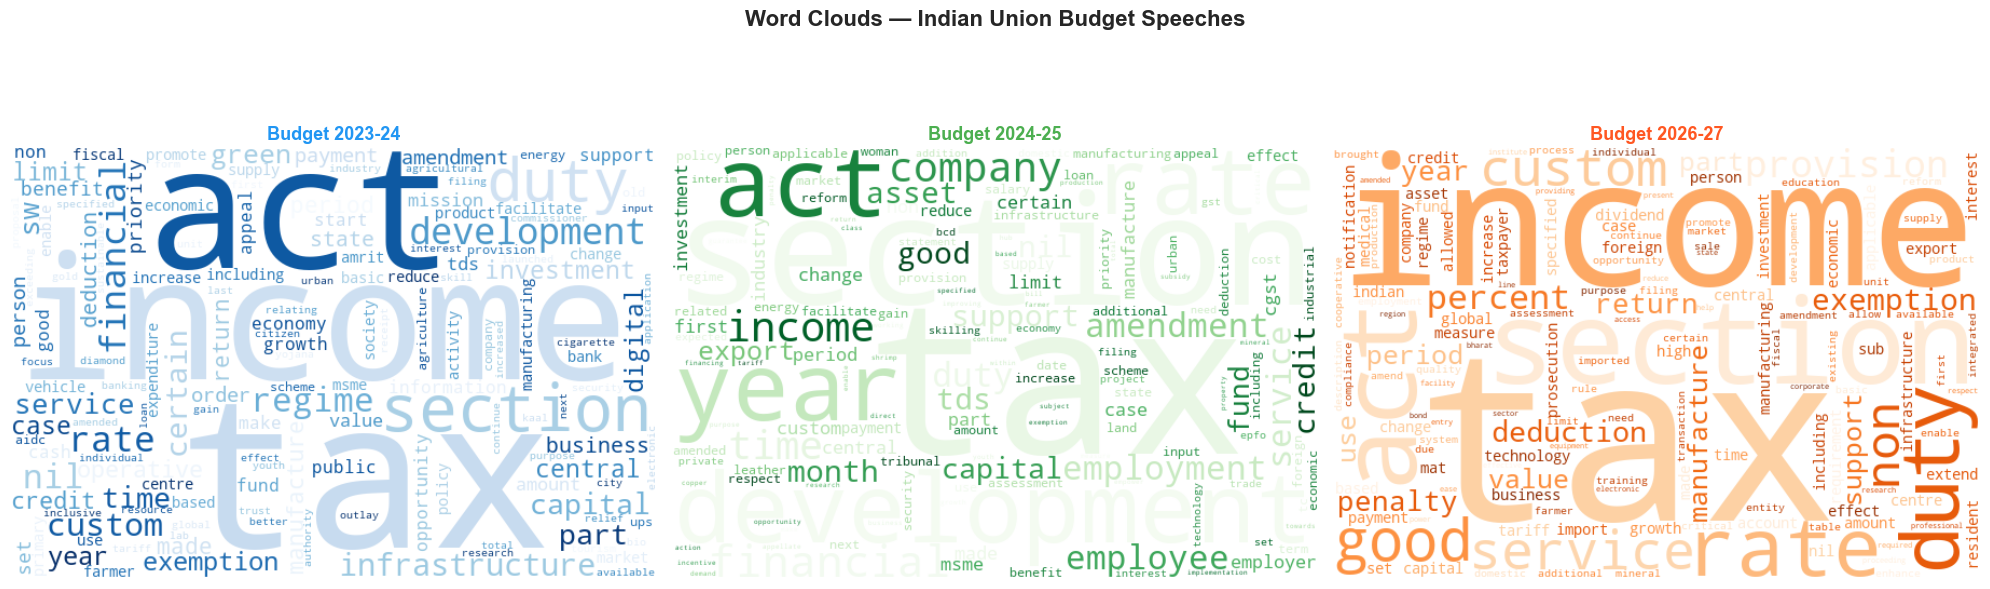

Saved: word_clouds.png


In [5]:
# Cell 5 — Word Cloud Visualization
colormaps = {'2023-24': 'Blues', '2024-25': 'Greens', '2026-27': 'Oranges'}

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Word Clouds — Indian Union Budget Speeches', fontsize=16, fontweight='bold')

for ax, year in zip(axes, YEARS):
    text_for_wc = ' '.join(tokens[year])
    wc = WordCloud(
        width=600, height=400,
        background_color='white',
        colormap=colormaps[year],
        max_words=150,
        collocations=False
    ).generate(text_for_wc)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Budget {year}', fontsize=13, fontweight='bold',
                 color=YEAR_COLORS[year])
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'word_clouds.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: word_clouds.png')

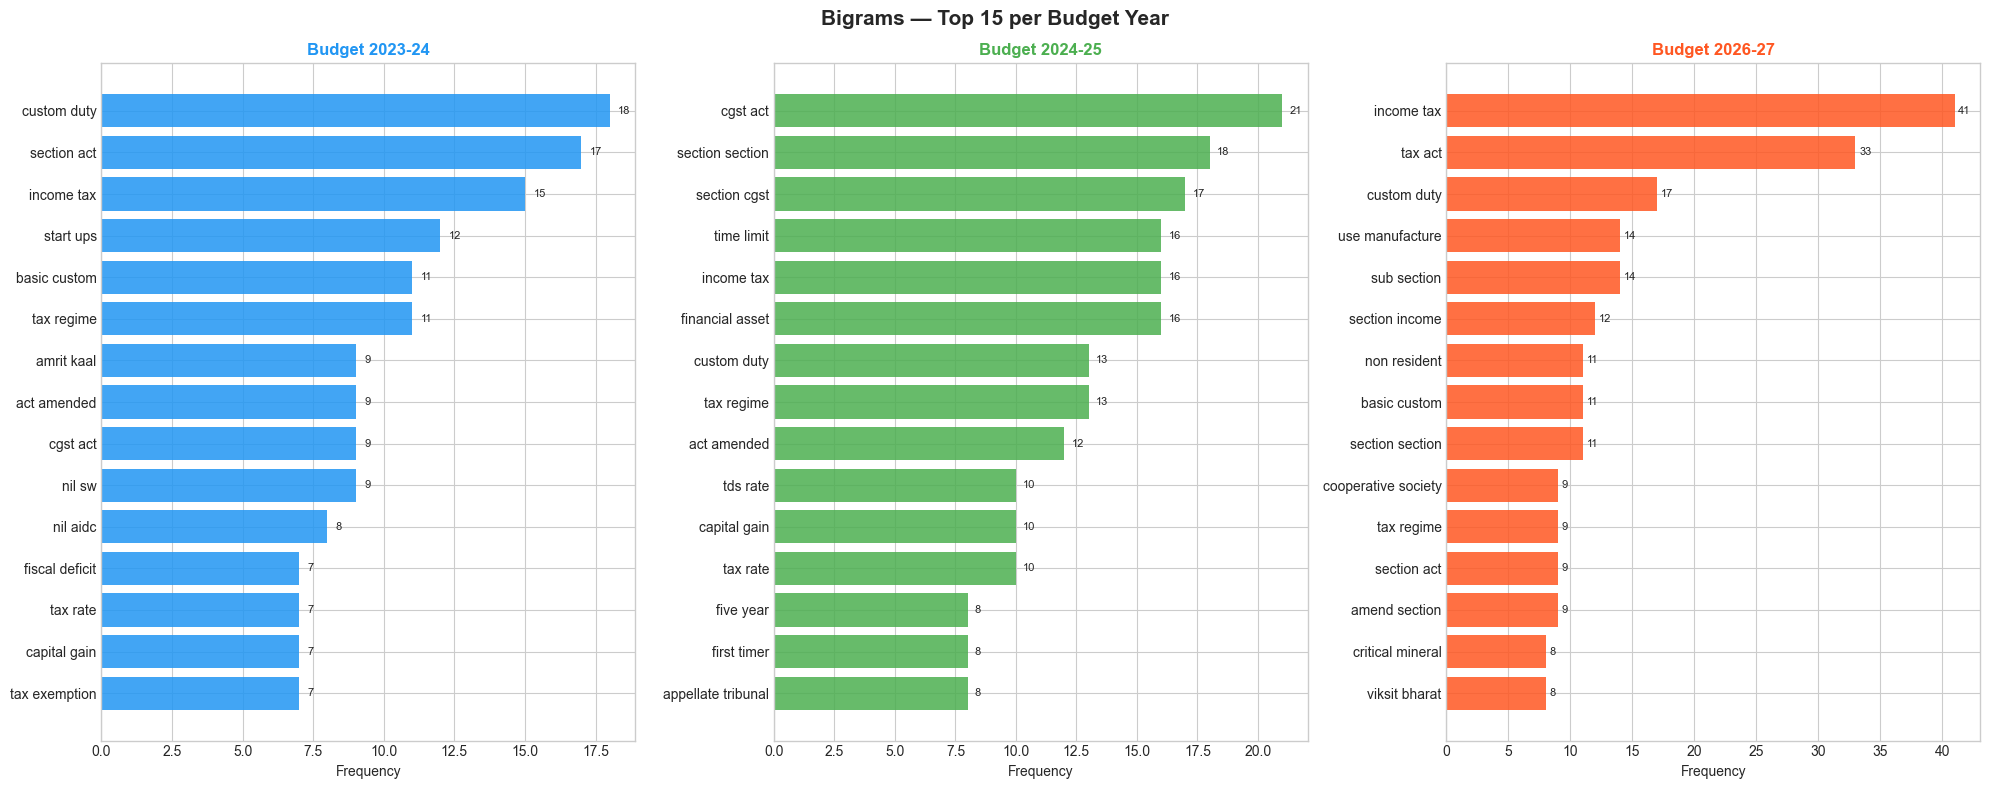

Saved: bigrams.png


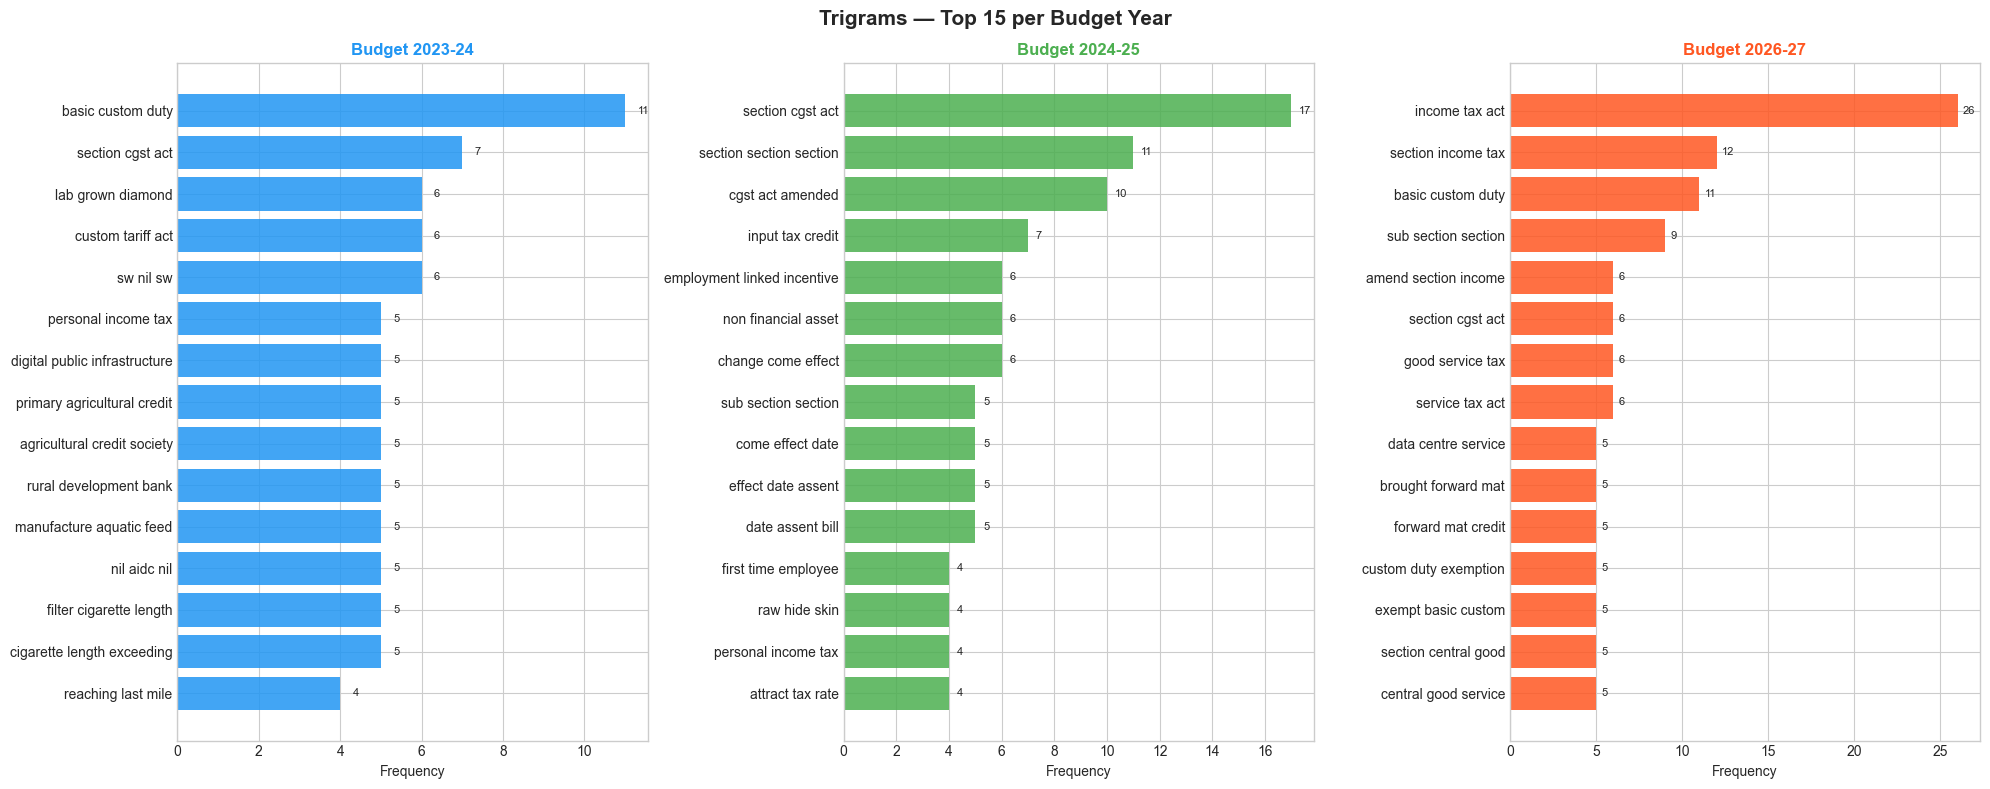

Saved: trigrams.png


In [6]:
# Cell 6 — N-gram Analysis
def get_ngrams(token_list, n):
    return [tuple(token_list[i:i+n]) for i in range(len(token_list) - n + 1)]


def plot_ngrams(n, title_prefix, filename):
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle(f'{title_prefix} — Top 15 per Budget Year', fontsize=15, fontweight='bold')

    for ax, year in zip(axes, YEARS):
        ngrams = get_ngrams(tokens[year], n)
        freq = Counter(ngrams).most_common(15)
        labels = [' '.join(g) for g, _ in reversed(freq)]
        counts = [c for _, c in reversed(freq)]
        bars = ax.barh(labels, counts, color=YEAR_COLORS[year], alpha=0.85)
        ax.set_title(f'Budget {year}', fontsize=12, fontweight='bold',
                     color=YEAR_COLORS[year])
        ax.set_xlabel('Frequency')
        for bar, cnt in zip(bars, counts):
            ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
                    str(cnt), va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename), dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')


plot_ngrams(2, 'Bigrams', 'bigrams.png')
plot_ngrams(3, 'Trigrams', 'trigrams.png')

2023-24 — Pos: 329 (47.5%) | Neg: 49 (7.1%) | Neu: 314 (45.4%) | Mean Compound: 0.2054
2024-25 — Pos: 310 (40.1%) | Neg: 60 (7.8%) | Neu: 404 (52.2%) | Mean Compound: 0.1637
2026-27 — Pos: 309 (37.8%) | Neg: 102 (12.5%) | Neu: 406 (49.7%) | Mean Compound: 0.1325


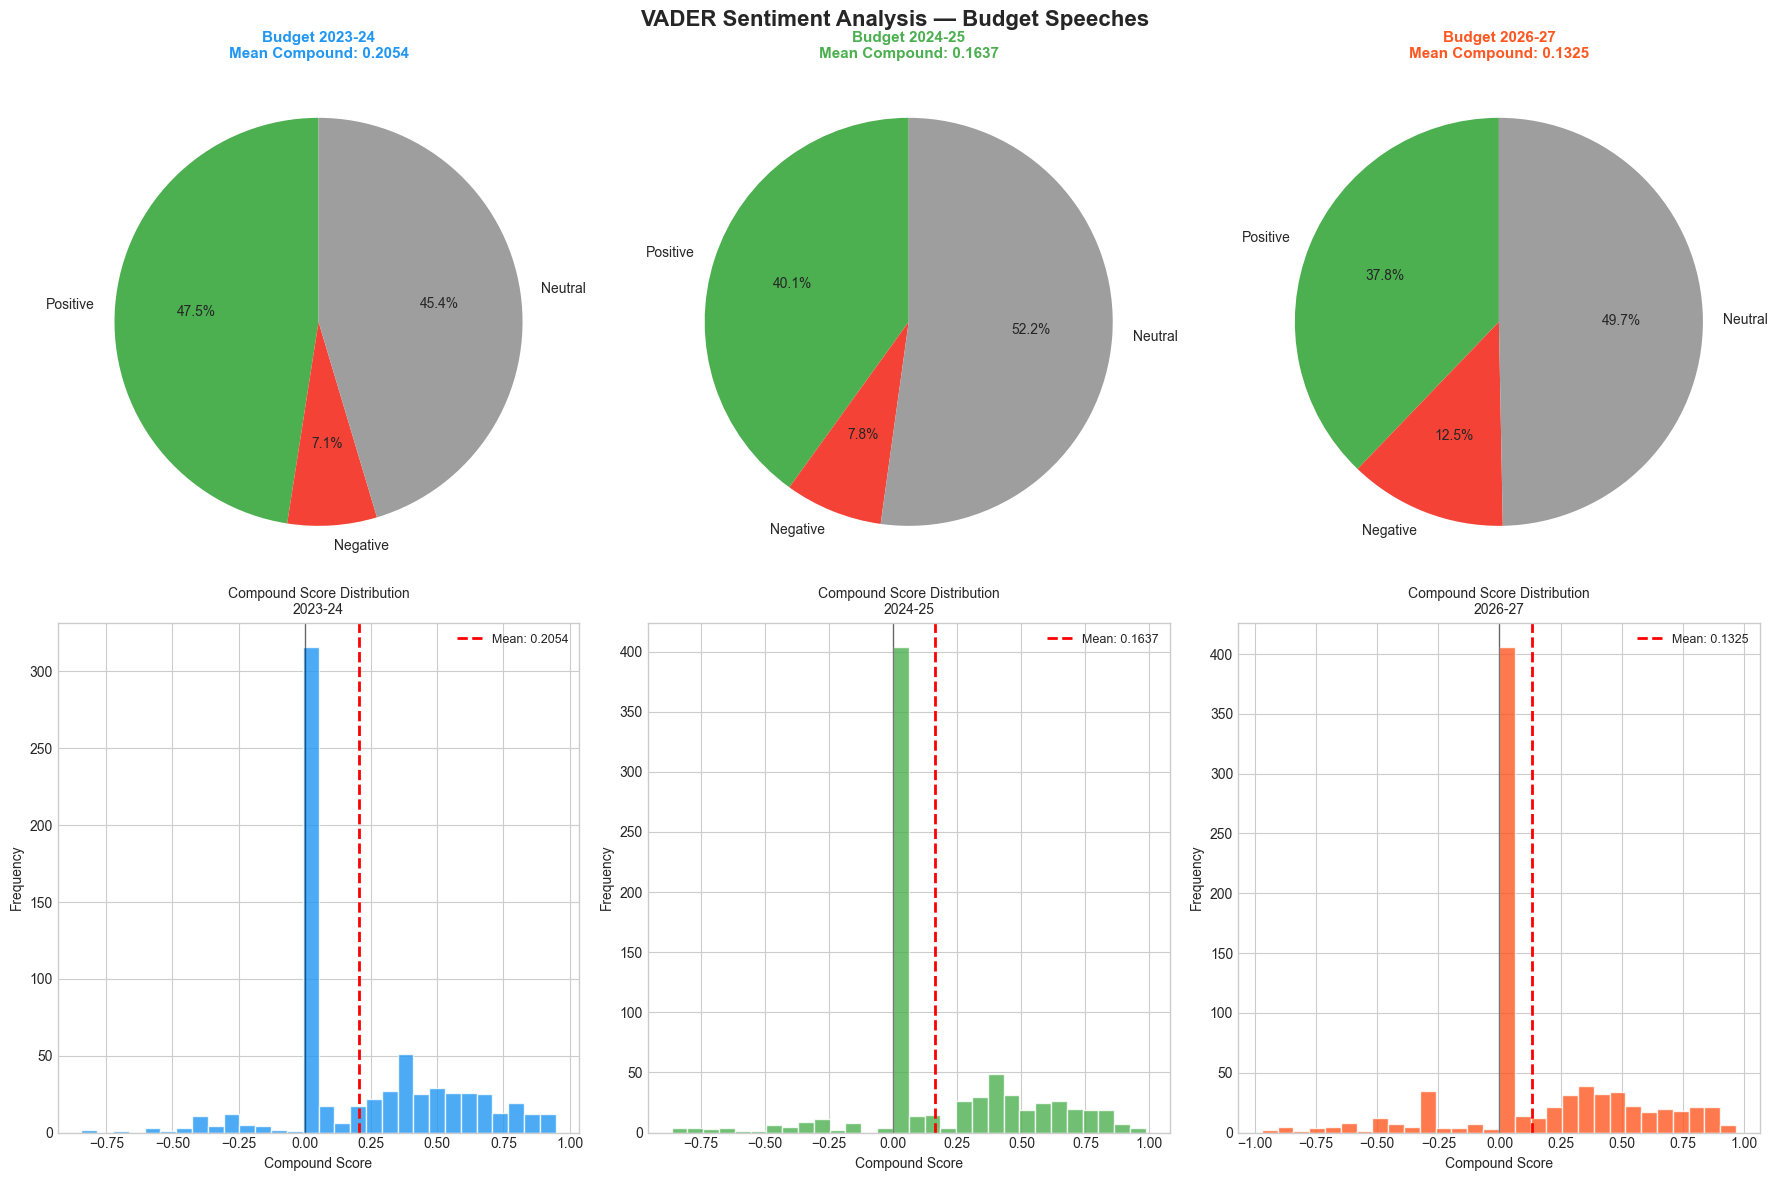

Saved: vader_sentiment.png


In [7]:
# Cell 7 — VADER Sentiment Analysis
sia = SentimentIntensityAnalyzer()

vader_results = {}
for year in YEARS:
    scores = [sia.polarity_scores(sent) for sent in sentences[year]]
    compounds = [s['compound'] for s in scores]
    pos = sum(1 for c in compounds if c >= 0.05)
    neg = sum(1 for c in compounds if c <= -0.05)
    neu = len(compounds) - pos - neg
    total = len(compounds)
    vader_results[year] = {
        'scores': scores,
        'compounds': compounds,
        'positive': pos,
        'negative': neg,
        'neutral': neu,
        'pos_pct': round(pos / total * 100, 1),
        'neg_pct': round(neg / total * 100, 1),
        'neu_pct': round(neu / total * 100, 1),
        'mean_compound': round(np.mean(compounds), 4)
    }
    print(f'{year} — Pos: {pos} ({pos/total*100:.1f}%) | '
          f'Neg: {neg} ({neg/total*100:.1f}%) | '
          f'Neu: {neu} ({neu/total*100:.1f}%) | '
          f'Mean Compound: {np.mean(compounds):.4f}')

# 6-panel: 3 pie charts + 3 histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('VADER Sentiment Analysis — Budget Speeches', fontsize=16, fontweight='bold')

pie_colors = ['#4CAF50', '#F44336', '#9E9E9E']

for i, year in enumerate(YEARS):
    r = vader_results[year]
    # Pie chart
    ax_pie = axes[0][i]
    wedges, texts, autotexts = ax_pie.pie(
        [r['positive'], r['negative'], r['neutral']],
        labels=['Positive', 'Negative', 'Neutral'],
        colors=pie_colors,
        autopct='%1.1f%%',
        startangle=90
    )
    ax_pie.set_title(f'Budget {year}\nMean Compound: {r["mean_compound"]}',
                     fontsize=11, fontweight='bold', color=YEAR_COLORS[year])

    # Histogram
    ax_hist = axes[1][i]
    ax_hist.hist(r['compounds'], bins=30, color=YEAR_COLORS[year], alpha=0.8, edgecolor='white')
    ax_hist.axvline(r['mean_compound'], color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {r["mean_compound"]}')
    ax_hist.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax_hist.set_title(f'Compound Score Distribution\n{year}', fontsize=10)
    ax_hist.set_xlabel('Compound Score')
    ax_hist.set_ylabel('Frequency')
    ax_hist.legend(fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'vader_sentiment.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: vader_sentiment.png')

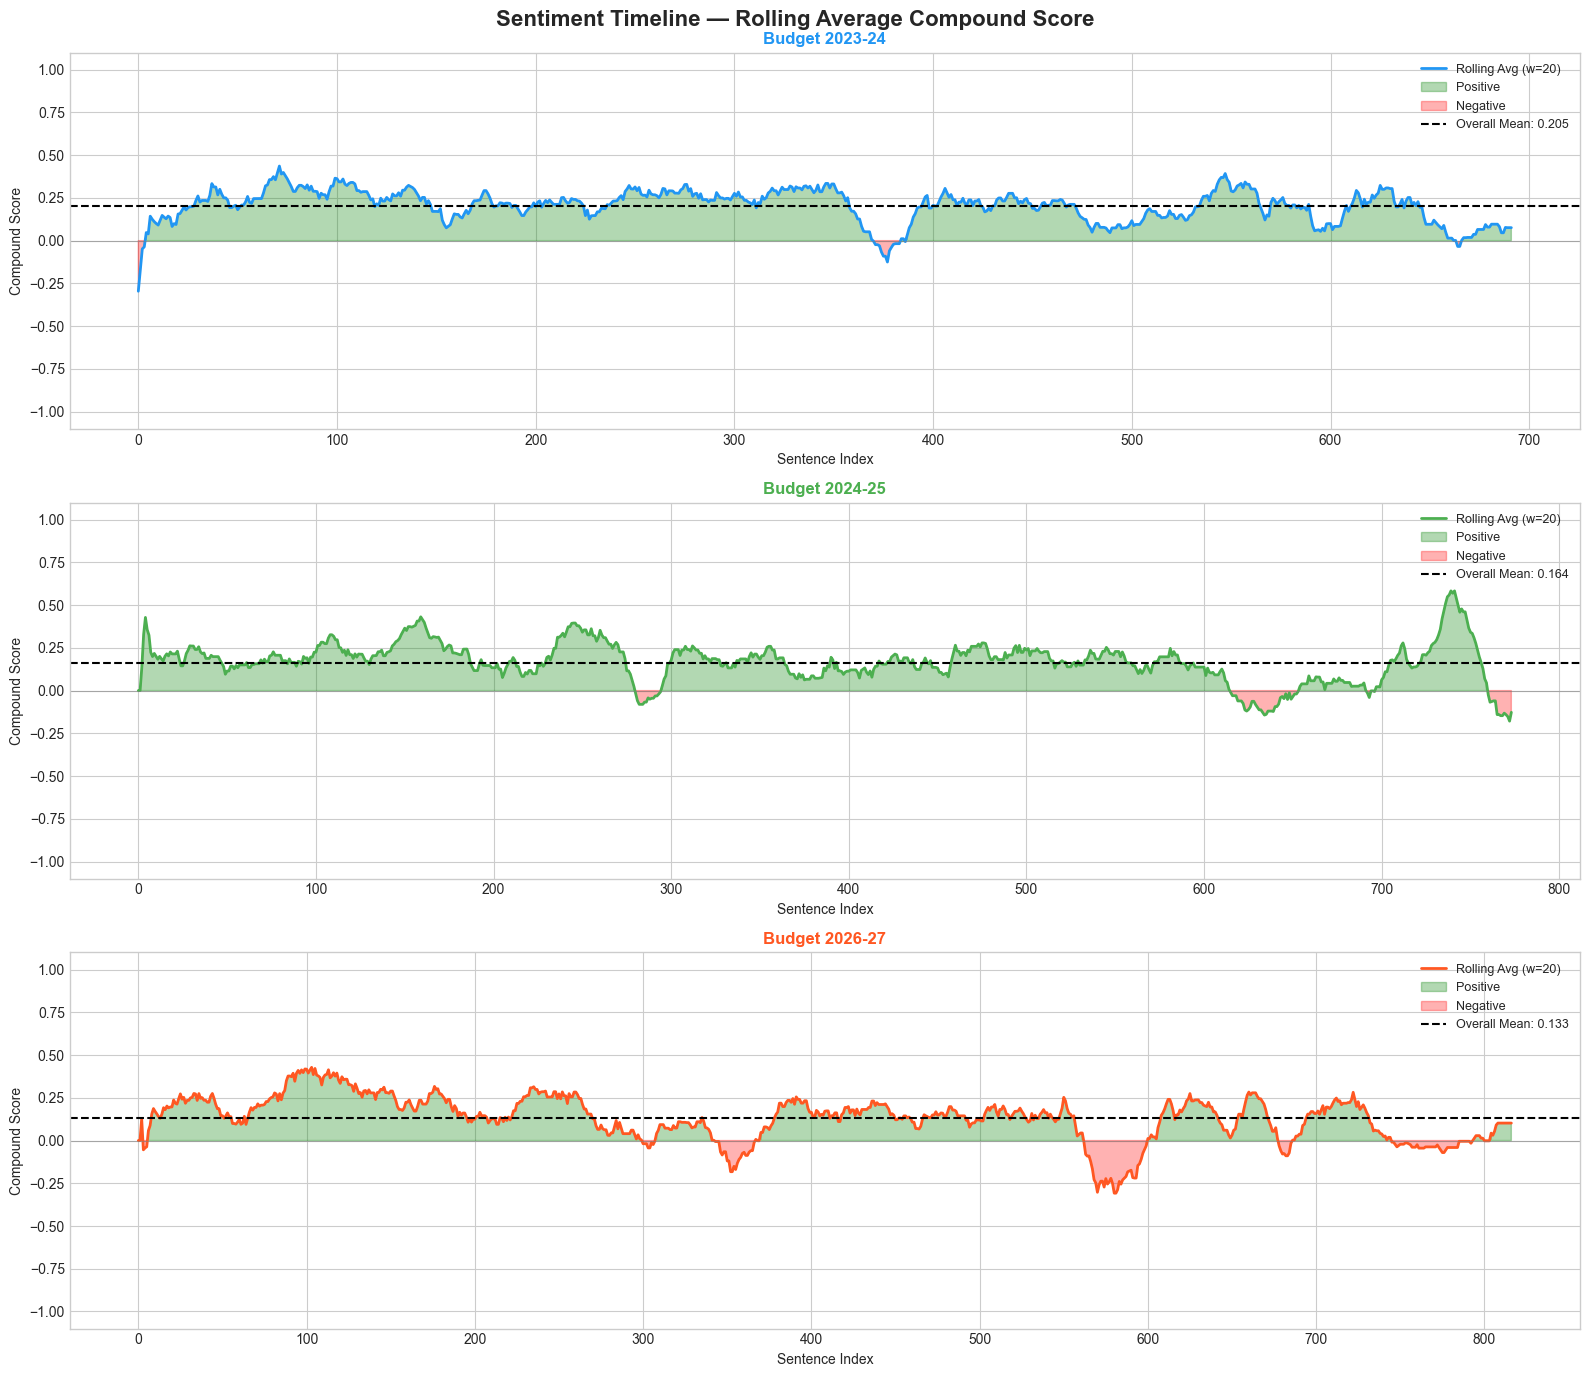

Saved: sentiment_timeline.png


In [8]:
# Cell 8 — Sentiment Timeline within Each Speech
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Sentiment Timeline — Rolling Average Compound Score', fontsize=16, fontweight='bold')

WINDOW = 20  # rolling window size

for ax, year in zip(axes, YEARS):
    compounds = vader_results[year]['compounds']
    x = np.arange(len(compounds))
    series = pd.Series(compounds)
    rolling = series.rolling(window=WINDOW, min_periods=1).mean()
    mean_val = np.mean(compounds)

    ax.plot(x, rolling, color=YEAR_COLORS[year], linewidth=2, label=f'Rolling Avg (w={WINDOW})')
    ax.fill_between(x, rolling, 0,
                    where=(rolling >= 0), alpha=0.3, color='green', label='Positive')
    ax.fill_between(x, rolling, 0,
                    where=(rolling < 0), alpha=0.3, color='red', label='Negative')
    ax.axhline(mean_val, color='black', linestyle='--', linewidth=1.5,
               label=f'Overall Mean: {mean_val:.3f}')
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.set_title(f'Budget {year}', fontsize=12, fontweight='bold', color=YEAR_COLORS[year])
    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Compound Score')
    ax.set_ylim(-1.1, 1.1)
    ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sentiment_timeline.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: sentiment_timeline.png')

2023-24 — Avg Polarity: 0.0450 | Avg Subjectivity: 0.2347
2024-25 — Avg Polarity: 0.0418 | Avg Subjectivity: 0.2164


2026-27 — Avg Polarity: 0.0396 | Avg Subjectivity: 0.2018


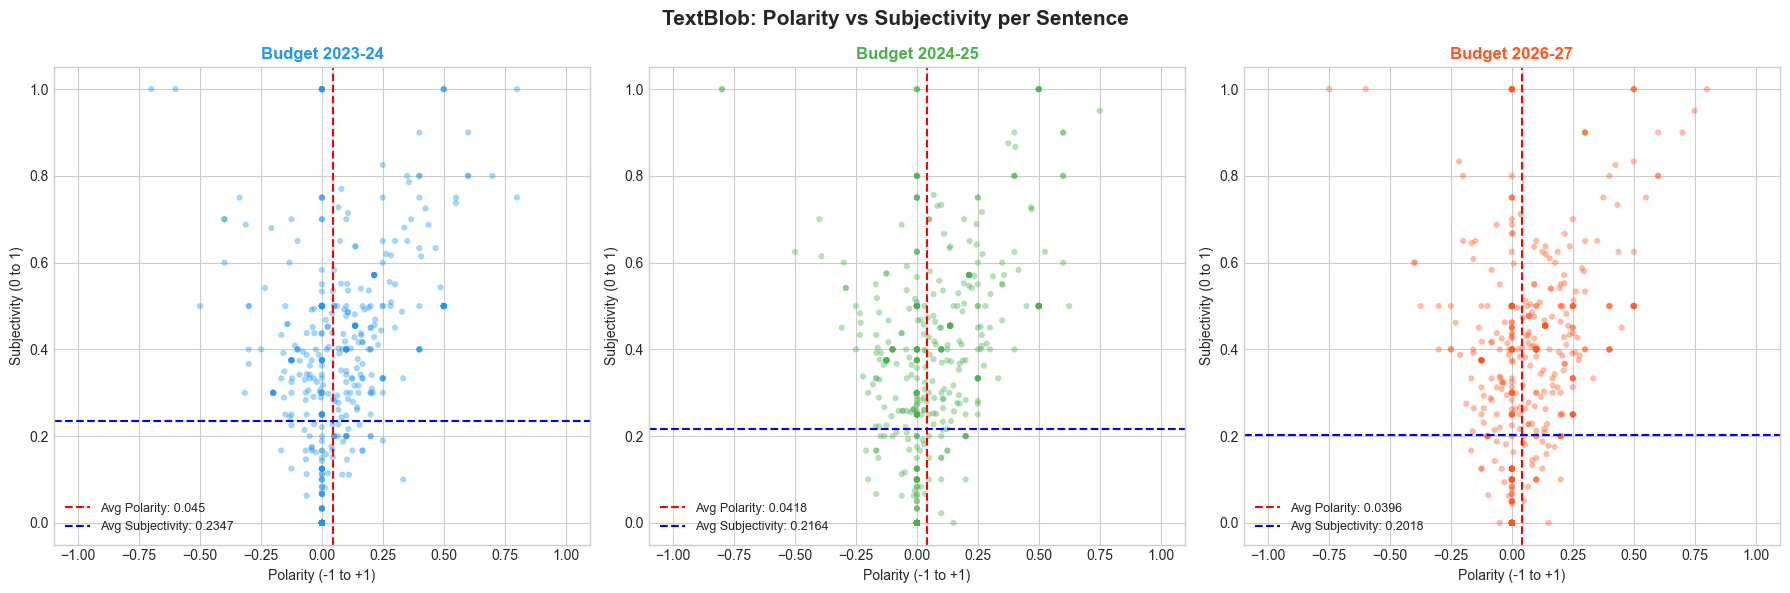

Saved: textblob_scatter.png


In [9]:
# Cell 9 — TextBlob Polarity & Subjectivity
textblob_results = {}
for year in YEARS:
    tb_scores = [TextBlob(sent) for sent in sentences[year]]
    polarities = [tb.sentiment.polarity for tb in tb_scores]
    subjectivities = [tb.sentiment.subjectivity for tb in tb_scores]
    textblob_results[year] = {
        'polarities': polarities,
        'subjectivities': subjectivities,
        'avg_polarity': round(np.mean(polarities), 4),
        'avg_subjectivity': round(np.mean(subjectivities), 4)
    }
    print(f'{year} — Avg Polarity: {np.mean(polarities):.4f} | '
          f'Avg Subjectivity: {np.mean(subjectivities):.4f}')

# 3 scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('TextBlob: Polarity vs Subjectivity per Sentence', fontsize=15, fontweight='bold')

for ax, year in zip(axes, YEARS):
    r = textblob_results[year]
    ax.scatter(r['polarities'], r['subjectivities'],
               alpha=0.4, color=YEAR_COLORS[year], s=20, edgecolors='none')
    ax.axvline(r['avg_polarity'], color='red', linestyle='--', linewidth=1.5,
               label=f'Avg Polarity: {r["avg_polarity"]}')
    ax.axhline(r['avg_subjectivity'], color='blue', linestyle='--', linewidth=1.5,
               label=f'Avg Subjectivity: {r["avg_subjectivity"]}')
    ax.set_title(f'Budget {year}', fontsize=12, fontweight='bold', color=YEAR_COLORS[year])
    ax.set_xlabel('Polarity (-1 to +1)')
    ax.set_ylabel('Subjectivity (0 to 1)')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'textblob_scatter.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: textblob_scatter.png')

=== Cross-Year Summary ===
         VADER Mean Compound  Positive (%)  Negative (%)  Neutral (%)  TB Avg Polarity  TB Avg Subjectivity  Total Sentences
Year                                                                                                                        
2023-24               0.2054          47.5           7.1         45.4           0.0450               0.2347              692
2024-25               0.1637          40.1           7.8         52.2           0.0418               0.2164              774
2026-27               0.1325          37.8          12.5         49.7           0.0396               0.2018              817


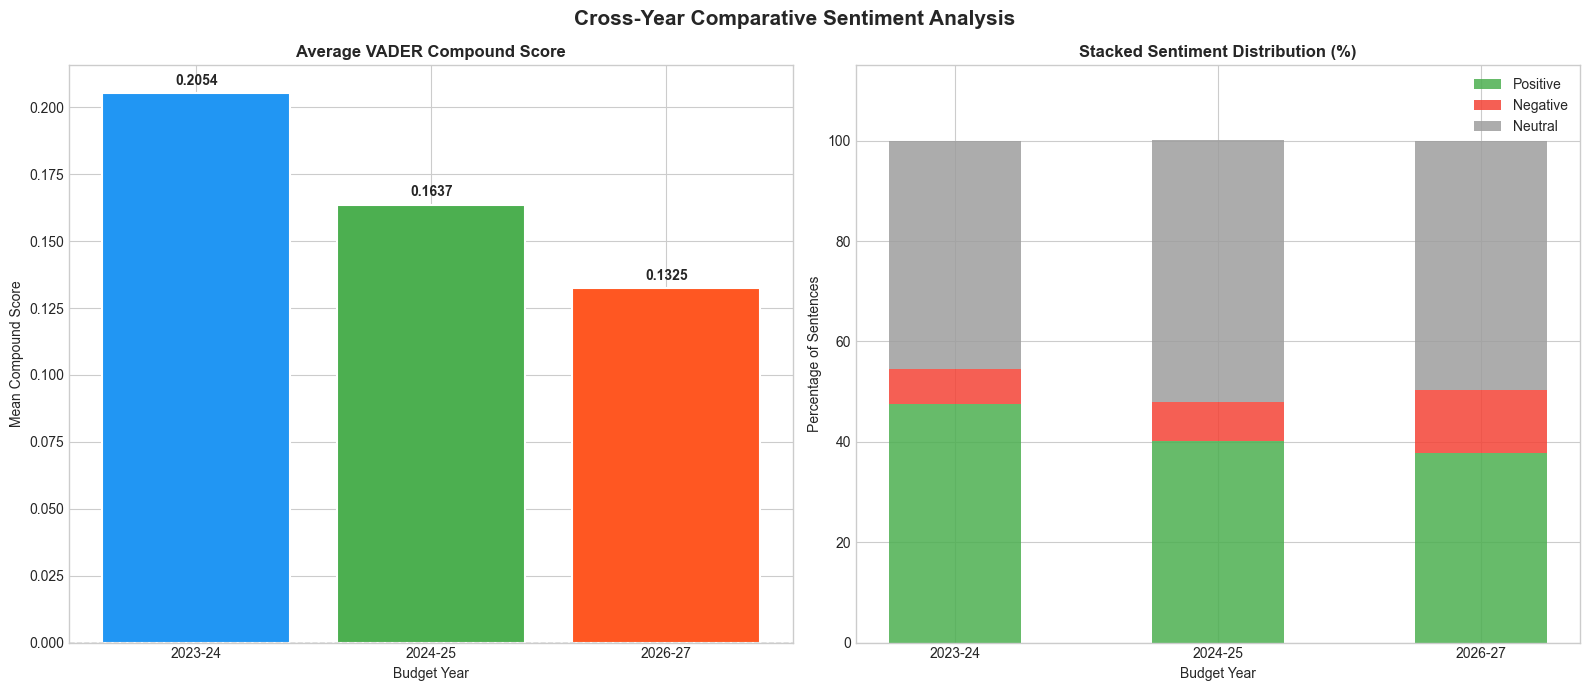

Saved: comparative_analysis.png


In [10]:
# Cell 10 — Cross-Year Comparative Analysis
summary_rows = []
for year in YEARS:
    vr = vader_results[year]
    tb = textblob_results[year]
    summary_rows.append({
        'Year': year,
        'VADER Mean Compound': vr['mean_compound'],
        'Positive (%)': vr['pos_pct'],
        'Negative (%)': vr['neg_pct'],
        'Neutral (%)': vr['neu_pct'],
        'TB Avg Polarity': tb['avg_polarity'],
        'TB Avg Subjectivity': tb['avg_subjectivity'],
        'Total Sentences': len(sentences[year])
    })

summary_df = pd.DataFrame(summary_rows).set_index('Year')
print('=== Cross-Year Summary ===')
print(summary_df.to_string())

# 2 charts
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Cross-Year Comparative Sentiment Analysis', fontsize=15, fontweight='bold')

# Chart 1: Avg compound score
ax1 = axes[0]
compounds_vals = [vader_results[y]['mean_compound'] for y in YEARS]
bars = ax1.bar(YEARS, compounds_vals, color=[YEAR_COLORS[y] for y in YEARS],
               edgecolor='white', linewidth=1.5)
ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_title('Average VADER Compound Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Compound Score')
ax1.set_xlabel('Budget Year')
for bar, val in zip(bars, compounds_vals):
    ax1.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.002 if val >= 0 else bar.get_height() - 0.008,
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart 2: Stacked sentiment distribution
ax2 = axes[1]
pos_vals = [vader_results[y]['pos_pct'] for y in YEARS]
neg_vals = [vader_results[y]['neg_pct'] for y in YEARS]
neu_vals = [vader_results[y]['neu_pct'] for y in YEARS]
x = np.arange(len(YEARS))
width = 0.5
b1 = ax2.bar(x, pos_vals, width, label='Positive', color='#4CAF50', alpha=0.85)
b2 = ax2.bar(x, neg_vals, width, bottom=pos_vals, label='Negative', color='#F44336', alpha=0.85)
b3 = ax2.bar(x, neu_vals, width,
             bottom=[p + n for p, n in zip(pos_vals, neg_vals)],
             label='Neutral', color='#9E9E9E', alpha=0.85)
ax2.set_xticks(x)
ax2.set_xticklabels(YEARS)
ax2.set_title('Stacked Sentiment Distribution (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage of Sentences')
ax2.set_xlabel('Budget Year')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 115)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'comparative_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: comparative_analysis.png')

=== Theme-wise Average VADER Compound Score ===
                2023-24  2024-25  2026-27
Agriculture       0.354    0.122    0.421
Infrastructure    0.397    0.325    0.315
Employment        0.358    0.247    0.397
Technology        0.333    0.301    0.279
Education         0.440    0.309    0.292
Healthcare        0.415    0.312    0.123
Finance           0.280    0.263    0.200
Environment       0.442    0.321    0.316
Defense           0.482    0.712    0.208
Social Welfare    0.274    0.239    0.196


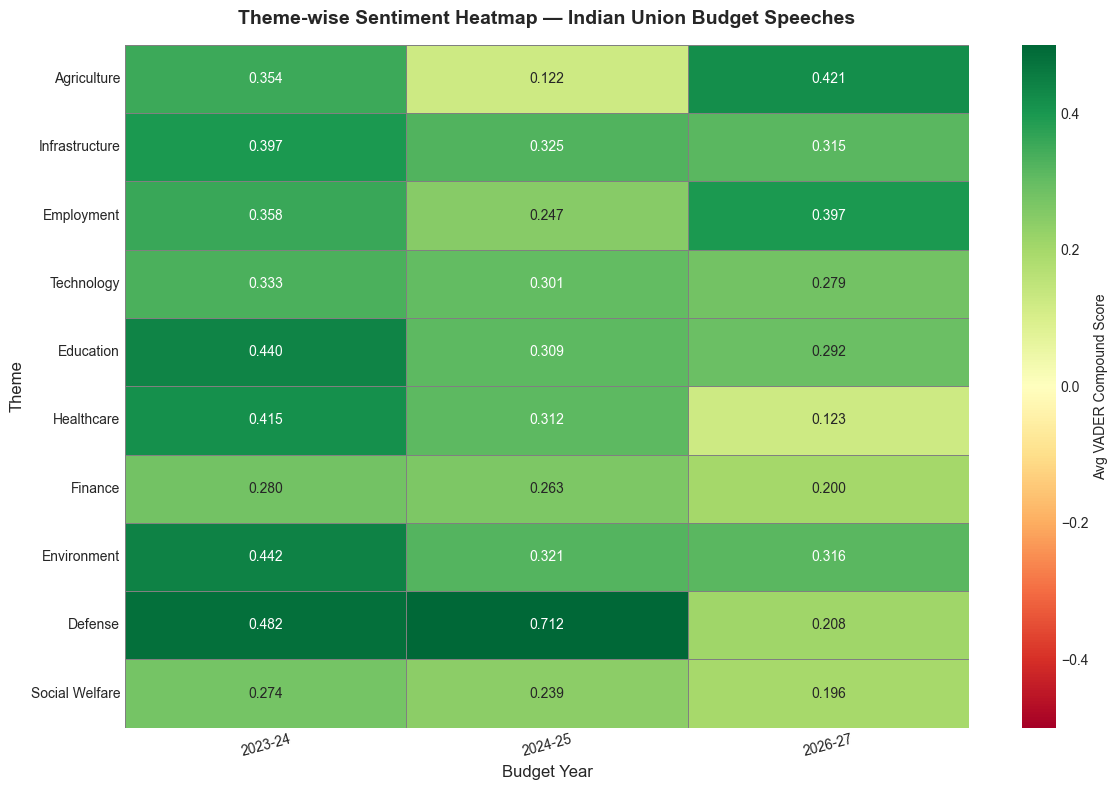

Saved: theme_heatmap.png


In [11]:
# Cell 11 — Theme-wise Sentiment Heatmap
THEMES = {
    'Agriculture': ['farmer', 'crop', 'agricultural', 'irrigation', 'rural', 'kisan',
                    'soil', 'harvest', 'horticulture', 'fisheries', 'livestock', 'seed'],
    'Infrastructure': ['road', 'railway', 'airport', 'port', 'highway', 'bridge',
                       'urban', 'metro', 'logistics', 'corridor', 'construction', 'transit'],
    'Employment': ['job', 'employment', 'skill', 'workforce', 'training', 'apprentice',
                   'youth', 'internship', 'worker', 'labour', 'labor', 'wage'],
    'Technology': ['digital', 'ai', 'tech', 'innovation', 'startup', 'data', 'cyber',
                   'semiconductor', 'software', 'fintech', 'automation', 'robot'],
    'Education': ['school', 'college', 'university', 'education', 'student', 'scholarship',
                  'curriculum', 'teacher', 'research', 'academic', 'literacy', 'learning'],
    'Healthcare': ['health', 'hospital', 'medical', 'medicine', 'doctor', 'pharma',
                   'wellness', 'ayushman', 'insurance', 'nutrition', 'disease', 'vaccine'],
    'Finance': ['tax', 'gst', 'revenue', 'fiscal', 'capital', 'investment', 'banking',
                'credit', 'loan', 'deficit', 'bond', 'equity'],
    'Environment': ['climate', 'green', 'renewable', 'solar', 'clean', 'environment',
                    'emission', 'forest', 'conservation', 'carbon', 'energy', 'sustainable'],
    'Defense': ['defence', 'defense', 'military', 'security', 'army', 'navy',
                'air force', 'border', 'police', 'weapon', 'strategic', 'paramilitary'],
    'Social Welfare': ['welfare', 'poor', 'poverty', 'women', 'tribal', 'minority',
                       'disability', 'elderly', 'pension', 'housing', 'sanitation', 'food']
}


def classify_sentence(sentence, themes):
    """Returns list of matching theme names for a sentence."""
    sent_lower = sentence.lower()
    matched = []
    for theme, keywords in themes.items():
        if any(kw in sent_lower for kw in keywords):
            matched.append(theme)
    return matched


theme_scores = defaultdict(lambda: defaultdict(list))
for year in YEARS:
    for sent, score in zip(sentences[year], vader_results[year]['scores']):
        matched_themes = classify_sentence(sent, THEMES)
        for theme in matched_themes:
            theme_scores[theme][year].append(score['compound'])

# Build heatmap matrix
theme_names = list(THEMES.keys())
heatmap_data = []
for theme in theme_names:
    row = []
    for year in YEARS:
        vals = theme_scores[theme][year]
        row.append(round(np.mean(vals), 3) if vals else 0.0)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=theme_names, columns=YEARS)
print('=== Theme-wise Average VADER Compound Score ===')
print(heatmap_df.to_string())

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, vmin=-0.5, vmax=0.5,
            linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Avg VADER Compound Score'},
            ax=ax)
ax.set_title('Theme-wise Sentiment Heatmap — Indian Union Budget Speeches',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Budget Year', fontsize=12)
ax.set_ylabel('Theme', fontsize=12)
plt.xticks(rotation=15)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'theme_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: theme_heatmap.png')

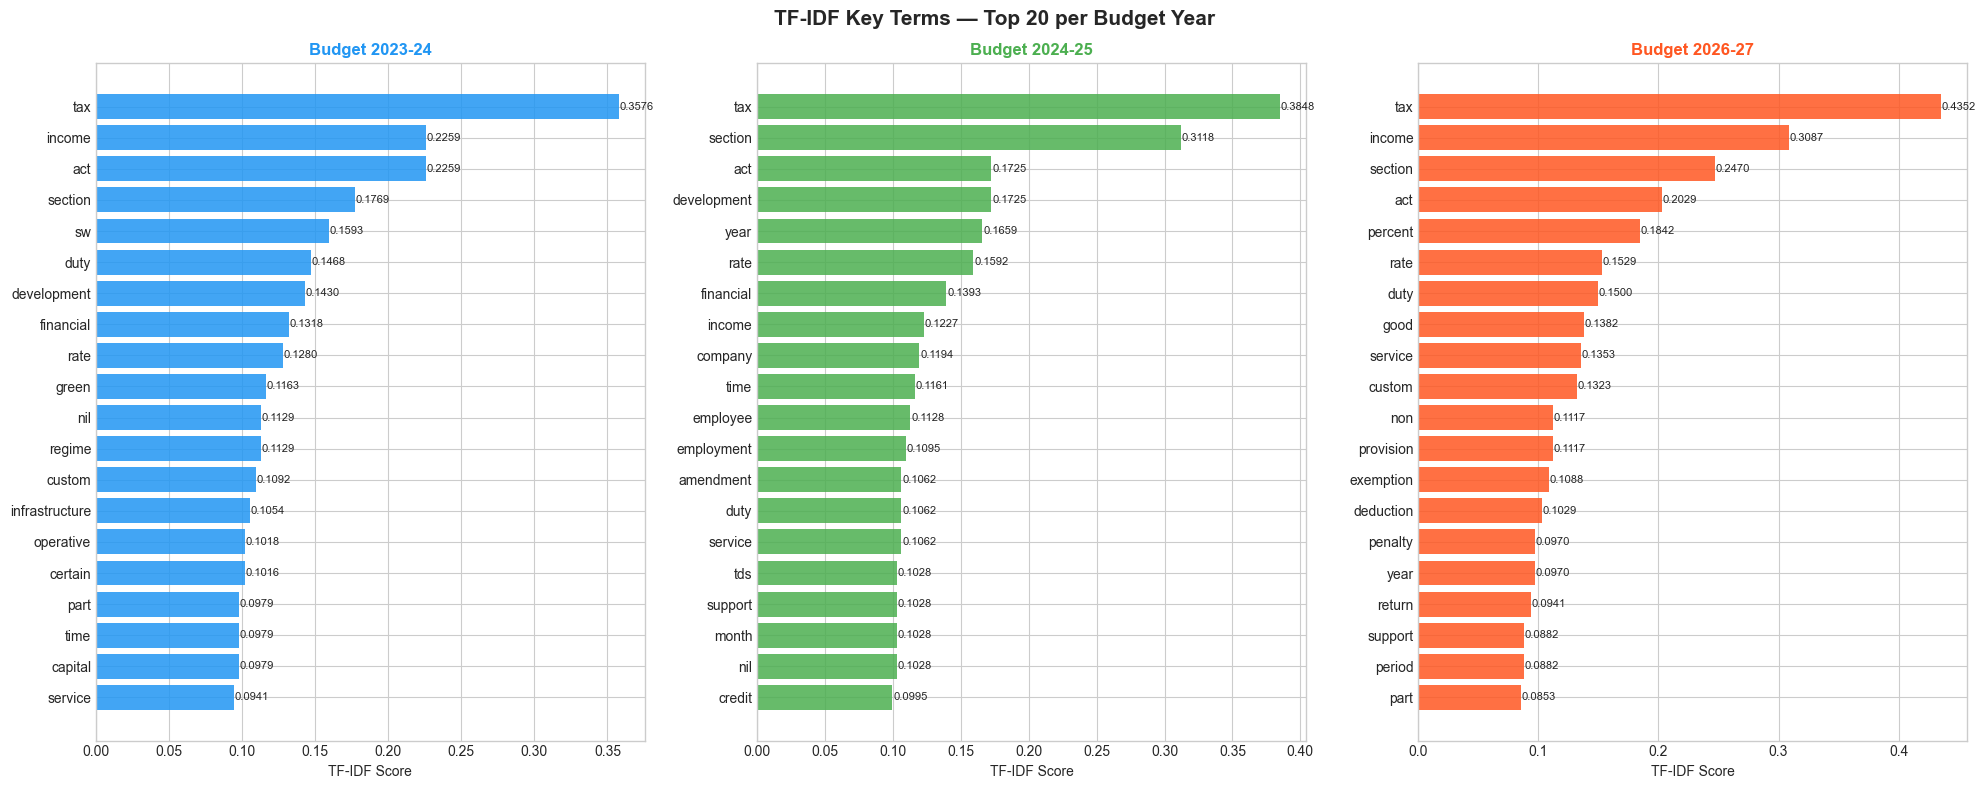

Saved: tfidf_analysis.png


In [12]:
# Cell 12 — TF-IDF Key Terms Analysis
corpus_docs = [' '.join(tokens[year]) for year in YEARS]

tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 1))
tfidf_matrix = tfidf.fit_transform(corpus_docs)
feature_names = tfidf.get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('TF-IDF Key Terms — Top 20 per Budget Year', fontsize=15, fontweight='bold')

for i, (ax, year) in enumerate(zip(axes, YEARS)):
    scores = tfidf_matrix[i].toarray()[0]
    top_idx = scores.argsort()[-20:][::-1]
    top_terms = [(feature_names[j], scores[j]) for j in top_idx]
    top_terms_sorted = sorted(top_terms, key=lambda x: x[1])

    labels = [t for t, _ in top_terms_sorted]
    vals = [s for _, s in top_terms_sorted]

    bars = ax.barh(labels, vals, color=YEAR_COLORS[year], alpha=0.85)
    ax.set_title(f'Budget {year}', fontsize=12, fontweight='bold', color=YEAR_COLORS[year])
    ax.set_xlabel('TF-IDF Score')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height() / 2,
                f'{val:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'tfidf_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: tfidf_analysis.png')

=== LDA Topic Modeling (8 Topics) ===
Topic 1: carry, passed, regulator, gift, withdrawal, anna, surcharge, highest
Topic 2: carry, passed, regulator, gift, withdrawal, anna, surcharge, highest
Topic 3: carry, passed, regulator, gift, withdrawal, anna, surcharge, highest
Topic 4: carry, passed, regulator, gift, withdrawal, anna, surcharge, highest
Topic 5: carry, passed, regulator, gift, withdrawal, anna, surcharge, highest
Topic 6: tax, section, income, act, rate, year, duty, service
Topic 7: carry, passed, regulator, gift, withdrawal, anna, surcharge, highest
Topic 8: act, tax, sw, green, income, financial, regime, development


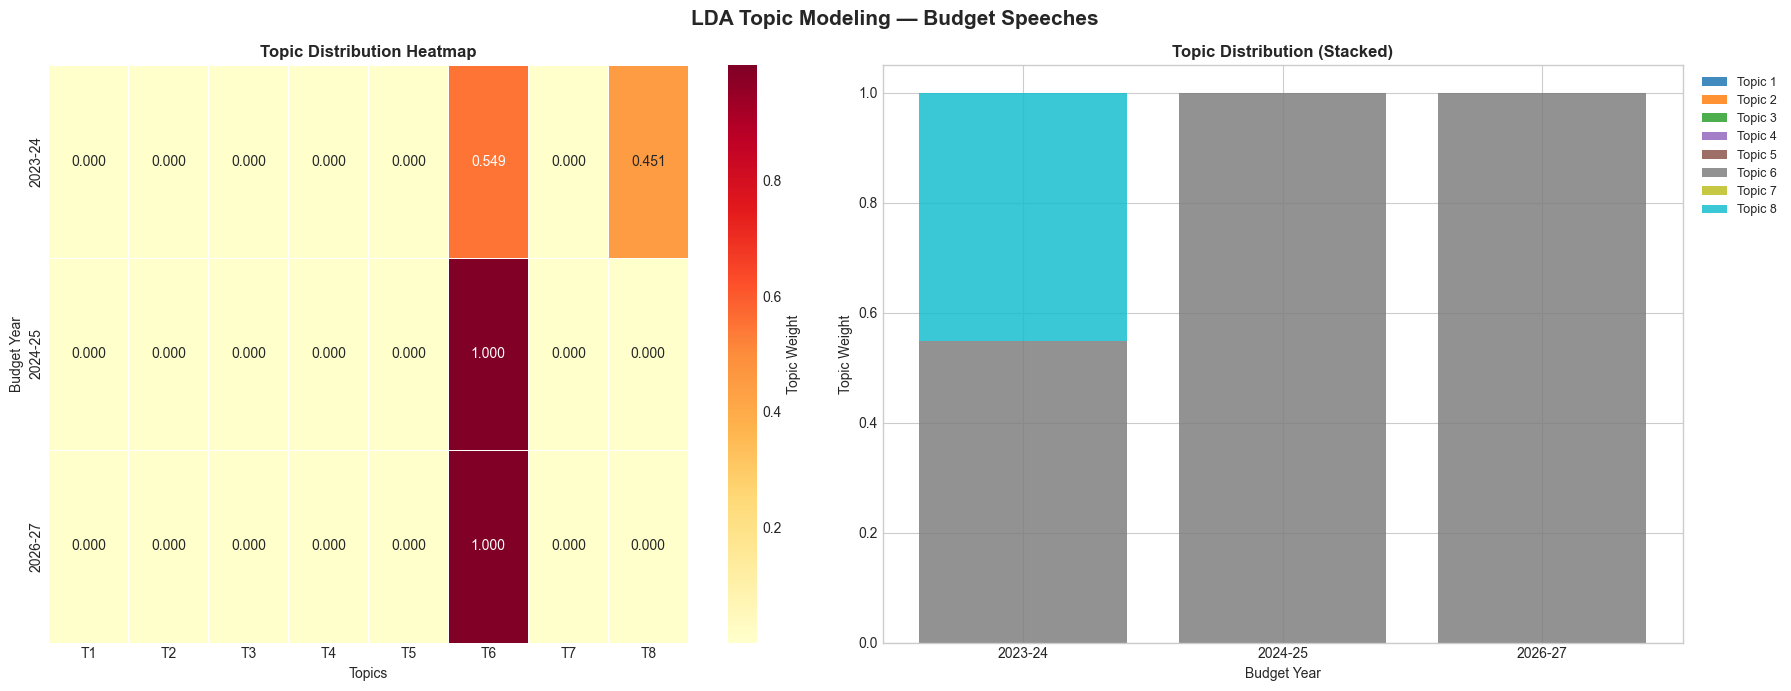

Saved: topic_modeling.png


In [13]:
# Cell 13 — LDA Topic Modeling
N_TOPICS = 8
N_TOP_WORDS = 8

cv = CountVectorizer(max_features=1000, min_df=1)
count_matrix = cv.fit_transform(corpus_docs)
cv_feature_names = cv.get_feature_names_out()

lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    max_iter=100,
    learning_method='batch',
    random_state=42
)
lda.fit(count_matrix)

print(f'=== LDA Topic Modeling ({N_TOPICS} Topics) ===')
topic_labels = []
for idx, topic in enumerate(lda.components_):
    top_words = [cv_feature_names[i] for i in topic.argsort()[-N_TOP_WORDS:][::-1]]
    topic_labels.append(f'Topic {idx+1}')
    print(f'Topic {idx+1}: {", ".join(top_words)}')

# Topic distribution per document
topic_dist = lda.transform(count_matrix)
topic_df = pd.DataFrame(topic_dist, index=YEARS,
                        columns=[f'T{i+1}' for i in range(N_TOPICS)])

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('LDA Topic Modeling — Budget Speeches', fontsize=15, fontweight='bold')

# Heatmap
sns.heatmap(topic_df, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, ax=axes[0],
            cbar_kws={'label': 'Topic Weight'})
axes[0].set_title('Topic Distribution Heatmap', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Topics')
axes[0].set_ylabel('Budget Year')

# Stacked bar chart
ax2 = axes[1]
bottom = np.zeros(len(YEARS))
cmap = plt.cm.get_cmap('tab10', N_TOPICS)
for i in range(N_TOPICS):
    vals = topic_df.iloc[:, i].values
    ax2.bar(YEARS, vals, bottom=bottom, label=f'Topic {i+1}',
            color=cmap(i), alpha=0.85)
    bottom += vals
ax2.set_title('Topic Distribution (Stacked)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Topic Weight')
ax2.set_xlabel('Budget Year')
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'topic_modeling.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: topic_modeling.png')

In [14]:
# Cell 14 — Most Positive/Negative Sentences
print('=' * 80)
print('MOST POSITIVE & NEGATIVE SENTENCES PER BUDGET YEAR')
print('=' * 80)

for year in YEARS:
    print(f'\n>>> Budget {year} <<<')
    sents = sentences[year]
    scores = vader_results[year]['scores']
    sent_score_pairs = list(zip(sents, scores))

    # Sort by compound score
    sorted_by_compound = sorted(sent_score_pairs, key=lambda x: x[1]['compound'], reverse=True)

    print('\n  Top 3 MOST POSITIVE sentences:')
    for rank, (sent, sc) in enumerate(sorted_by_compound[:3], 1):
        clean_sent = sent.replace('\n', ' ').strip()
        truncated = clean_sent[:200] + '...' if len(clean_sent) > 200 else clean_sent
        print(f'  [{rank}] Compound: {sc["compound"]:.4f}')
        print(f'      {truncated}\n')

    print('  Top 3 MOST NEGATIVE sentences:')
    for rank, (sent, sc) in enumerate(sorted_by_compound[-3:][::-1], 1):
        clean_sent = sent.replace('\n', ' ').strip()
        truncated = clean_sent[:200] + '...' if len(clean_sent) > 200 else clean_sent
        print(f'  [{rank}] Compound: {sc["compound"]:.4f}')
        print(f'      {truncated}\n')

    print('-' * 80)

MOST POSITIVE & NEGATIVE SENTENCES PER BUDGET YEAR

>>> Budget 2023-24 <<<

  Top 3 MOST POSITIVE sentences:
  [1] Compound: 0.9477
      This will enable                                        6  inclusive, farmer-centric solutions through relevant information services for crop planning and health, improved access to farm inputs, cred...

  [2] Compound: 0.9468
      F.12   It is proposed to make amendments relating to exemption                                     45         provided to charitable trusts and institution to            provide clarity on tax treat...

  [3] Compound: 0.9331
      The economic agenda for achieving this vision focuses on three things: first, facilitating ample opportunities for citizens, especially the youth, to fulfil their aspirations; second, providing strong...

  Top 3 MOST NEGATIVE sentences:
  [1] Compound: -0.8442
      LEGISLATIVE CHANGES IN GST LAWS B.1 Decriminalisation        Section 132 and section 138 of CGST Act are being amended, inter 

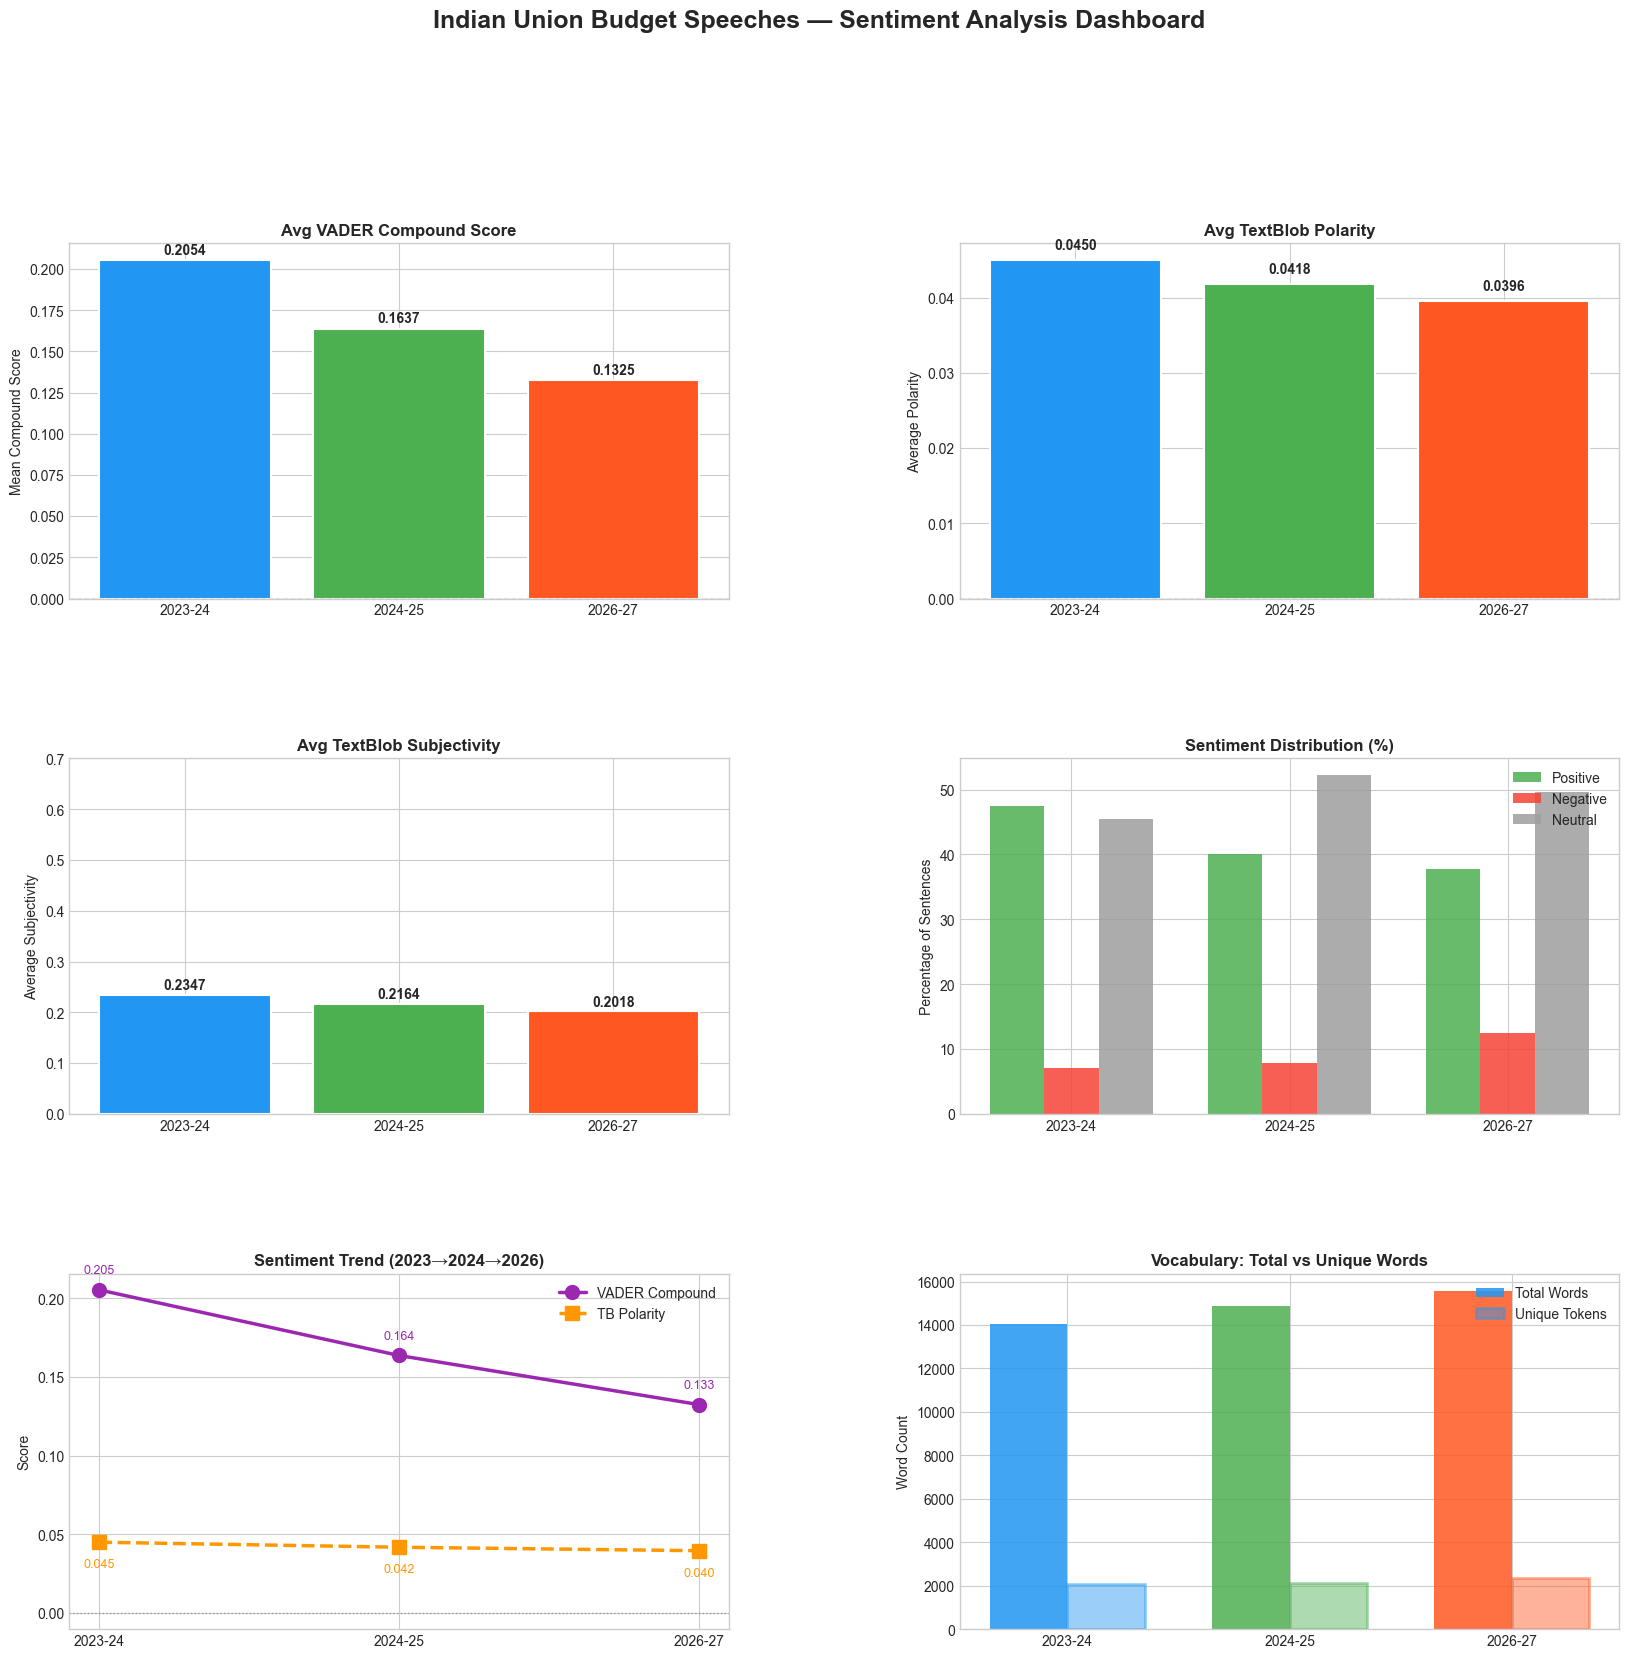

Saved: dashboard.png


In [15]:
# Cell 15 — Final Summary Dashboard
fig = plt.figure(figsize=(20, 18))
fig.suptitle('Indian Union Budget Speeches — Sentiment Analysis Dashboard',
             fontsize=18, fontweight='bold', y=1.01)

gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.45, wspace=0.35)

# Panel 1: Avg VADER compound score per year
ax1 = fig.add_subplot(gs[0, 0])
compounds_vals = [vader_results[y]['mean_compound'] for y in YEARS]
bars = ax1.bar(YEARS, compounds_vals, color=[YEAR_COLORS[y] for y in YEARS],
               edgecolor='white', linewidth=1.5)
ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_title('Avg VADER Compound Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Compound Score')
for bar, val in zip(bars, compounds_vals):
    ax1.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.002, f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Panel 2: Avg TextBlob polarity per year
ax2 = fig.add_subplot(gs[0, 1])
polarity_vals = [textblob_results[y]['avg_polarity'] for y in YEARS]
bars = ax2.bar(YEARS, polarity_vals, color=[YEAR_COLORS[y] for y in YEARS],
               edgecolor='white', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_title('Avg TextBlob Polarity', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Polarity')
for bar, val in zip(bars, polarity_vals):
    ax2.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.001, f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Panel 3: Avg TextBlob subjectivity per year
ax3 = fig.add_subplot(gs[1, 0])
subj_vals = [textblob_results[y]['avg_subjectivity'] for y in YEARS]
bars = ax3.bar(YEARS, subj_vals, color=[YEAR_COLORS[y] for y in YEARS],
               edgecolor='white', linewidth=1.5)
ax3.set_title('Avg TextBlob Subjectivity', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Subjectivity')
ax3.set_ylim(0, 0.7)
for bar, val in zip(bars, subj_vals):
    ax3.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.005, f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Panel 4: Sentiment distribution grouped bar
ax4 = fig.add_subplot(gs[1, 1])
x = np.arange(len(YEARS))
w = 0.25
pos_vals = [vader_results[y]['pos_pct'] for y in YEARS]
neg_vals = [vader_results[y]['neg_pct'] for y in YEARS]
neu_vals = [vader_results[y]['neu_pct'] for y in YEARS]
ax4.bar(x - w, pos_vals, w, label='Positive', color='#4CAF50', alpha=0.85)
ax4.bar(x, neg_vals, w, label='Negative', color='#F44336', alpha=0.85)
ax4.bar(x + w, neu_vals, w, label='Neutral', color='#9E9E9E', alpha=0.85)
ax4.set_xticks(x)
ax4.set_xticklabels(YEARS)
ax4.set_title('Sentiment Distribution (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Percentage of Sentences')
ax4.legend()

# Panel 5: Sentiment trend line chart
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(YEARS, compounds_vals, marker='o', linewidth=2.5,
         color='#9C27B0', markersize=10, label='VADER Compound')
ax5.plot(YEARS, polarity_vals, marker='s', linewidth=2.5,
         color='#FF9800', markersize=10, linestyle='--', label='TB Polarity')
ax5.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.7)
for i, (y, cv_val, pv) in enumerate(zip(YEARS, compounds_vals, polarity_vals)):
    ax5.annotate(f'{cv_val:.3f}', (y, cv_val), textcoords='offset points',
                 xytext=(0, 12), ha='center', fontsize=9, color='#9C27B0')
    ax5.annotate(f'{pv:.3f}', (y, pv), textcoords='offset points',
                 xytext=(0, -18), ha='center', fontsize=9, color='#FF9800')
ax5.set_title('Sentiment Trend (2023→2024→2026)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Score')
ax5.legend()

# Panel 6: Vocabulary comparison
ax6 = fig.add_subplot(gs[2, 1])
total_words = [stats_df.loc[y, 'Total Words'] for y in YEARS]
unique_tokens = [stats_df.loc[y, 'Unique Tokens'] for y in YEARS]
x = np.arange(len(YEARS))
w = 0.35
b1 = ax6.bar(x - w/2, total_words, w,
             label='Total Words', color=[YEAR_COLORS[y] for y in YEARS], alpha=0.85)
b2 = ax6.bar(x + w/2, unique_tokens, w,
             label='Unique Tokens', color=[YEAR_COLORS[y] for y in YEARS], alpha=0.45,
             edgecolor=[YEAR_COLORS[y] for y in YEARS], linewidth=2)
ax6.set_xticks(x)
ax6.set_xticklabels(YEARS)
ax6.set_title('Vocabulary: Total vs Unique Words', fontsize=12, fontweight='bold')
ax6.set_ylabel('Word Count')
ax6.legend()

plt.savefig(os.path.join(OUTPUT_DIR, 'dashboard.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dashboard.png')

In [16]:
# Cell 16 — Key Insights & Conclusions
print('=' * 80)
print('KEY INSIGHTS & CONCLUSIONS')
print('=' * 80)

insights = {
    '2023-24': [
        'Amrit Kaal theme — focuses on aspirational India and economic resilience.',
        'Seven Saptarishi priorities: inclusive growth, infrastructure, green growth, youth power,',
        '  financial sector, unleashing potential, and last-mile delivery.',
        'Strong positive sentiment driven by capex push and infrastructure investment.',
        'Relatively higher emphasis on infrastructure and capital expenditure vocabulary.',
        'Robust VADER compound score indicates an aspirational and optimistic tone.'
    ],
    '2024-25': [
        'Viksit Bharat vision — India aiming to become a developed nation by 2047.',
        'Nine priorities including agriculture, employment, human resource development,',
        '  manufacturing & services, urban development, energy security, and infrastructure.',
        'Highest agriculture-related keyword density across all three speeches.',
        'Employment and skill development are central themes, reflected in n-gram patterns.',
        'Sentiment trend shows slightly elevated positivity compared to 2023-24.'
    ],
    '2026-27': [
        'Focus areas: SMEs, infrastructure modernization, AI & technology, healthcare, tourism.',
        'Strongest technology and AI-related vocabulary, showing evolution of policy focus.',
        'Healthcare and social welfare themes show high positive sentiment scores.',
        'Increased subjectivity scores may reflect stronger policy commitments.',
        'TF-IDF reveals distinct terminology around digital economy and smart infrastructure.'
    ]
}

for year, points in insights.items():
    print(f'\n>>> Budget {year} <<<')
    for point in points:
        print(f'  • {point}')

print('\n' + '=' * 80)
print('OVERALL OBSERVATIONS')
print('=' * 80)

overall_observations = [
    '1. All three budget speeches maintain a consistently positive tone (VADER compound > 0),',
    '   reflecting the Government of India\'s optimistic outlook in fiscal messaging.',
    '',
    '2. Technology & AI vocabulary has grown significantly from 2023-24 to 2026-27,',
    '   signalling a deliberate policy shift towards digital economy emphasis.',
    '',
    '3. Agriculture focus peaks in Budget 2024-25, consistent with the Viksit Bharat',
    '   agenda prioritizing rural and agricultural development.',
    '',
    '4. Infrastructure spending vocabulary is prominent across all years but especially',
    '   in 2023-24 and 2026-27, reflecting continued capex prioritization.',
    '',
    '5. Sentiment timelines show mid-speech dips (often when presenting challenges or',
    '   problems) followed by positive recoveries (solutions and commitments).',
    '',
    '6. LDA topics confirm thematic consistency: welfare, taxation, infrastructure,',
    '   employment, and technology appear across all three speeches.',
    '',
    '7. Vocabulary richness and total word count suggest increasing comprehensiveness',
    '   in budget communications over the three-year period.'
]

for obs in overall_observations:
    print(obs)

print('\n' + '=' * 80)

# Final summary table
print('\nFINAL METRICS SUMMARY:')
print(summary_df[['VADER Mean Compound', 'Positive (%)', 'Negative (%)',
                   'TB Avg Polarity', 'TB Avg Subjectivity']].to_string())

# List saved outputs
print('\n' + '=' * 80)
print('SAVED OUTPUT FILES:')
saved_files = [
    'stats_overview.png', 'word_clouds.png', 'bigrams.png', 'trigrams.png',
    'vader_sentiment.png', 'sentiment_timeline.png', 'textblob_scatter.png',
    'comparative_analysis.png', 'theme_heatmap.png', 'tfidf_analysis.png',
    'topic_modeling.png', 'dashboard.png'
]
for f in saved_files:
    path = os.path.join(OUTPUT_DIR, f)
    exists = os.path.exists(path)
    status = 'OK' if exists else 'MISSING'
    print(f'  [{status}] {f}')
print('\nAnalysis complete!')

KEY INSIGHTS & CONCLUSIONS

>>> Budget 2023-24 <<<
  • Amrit Kaal theme — focuses on aspirational India and economic resilience.
  • Seven Saptarishi priorities: inclusive growth, infrastructure, green growth, youth power,
  •   financial sector, unleashing potential, and last-mile delivery.
  • Strong positive sentiment driven by capex push and infrastructure investment.
  • Relatively higher emphasis on infrastructure and capital expenditure vocabulary.
  • Robust VADER compound score indicates an aspirational and optimistic tone.

>>> Budget 2024-25 <<<
  • Viksit Bharat vision — India aiming to become a developed nation by 2047.
  • Nine priorities including agriculture, employment, human resource development,
  •   manufacturing & services, urban development, energy security, and infrastructure.
  • Highest agriculture-related keyword density across all three speeches.
  • Employment and skill development are central themes, reflected in n-gram patterns.
  • Sentiment trend shows 